In [86]:
!pip install yfinance plotly scikit-learn statsmodels tensorflow shap

import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math
import shap

def fetch_ftse100_data(period='1d', interval='1m'):
    ftse100 = yf.Ticker("^FTSE")
    data = ftse100.history(period=period, interval=interval)
    return data

data = fetch_ftse100_data()
print(data)

                                  Open         High          Low        Close  \
Datetime                                                                        
2024-09-04 08:00:00+01:00  8298.459961  8298.459961  8220.790039  8220.790039   
2024-09-04 08:01:00+01:00  8221.009766  8231.490234  8219.290039  8231.490234   
2024-09-04 08:02:00+01:00  8231.799805  8231.799805  8225.419922  8229.209961   
2024-09-04 08:03:00+01:00  8229.019531  8232.049805  8228.660156  8230.150391   
2024-09-04 08:04:00+01:00  8229.759766  8233.330078  8229.469727  8232.980469   
...                                ...          ...          ...          ...   
2024-09-04 16:25:00+01:00  8269.940430  8270.099609  8268.790039  8270.099609   
2024-09-04 16:26:00+01:00  8270.129883  8270.259766  8267.820312  8267.849609   
2024-09-04 16:27:00+01:00  8267.809570  8268.040039  8267.450195  8267.509766   
2024-09-04 16:28:00+01:00  8267.370117  8267.370117  8265.639648  8266.419922   
2024-09-04 16:29:00+01:00  8

**Adding Moving Average**

In [87]:
data['Moving Average'] = data['Close'].rolling(window=20).mean()

**Linear Regression Model**

**Predict today's price using Linear Regression**

In [88]:
data['Shifted Close'] = data['Close'].shift(-1)
data.dropna(inplace=True)

X = data[['Close']]
y = data['Shifted Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Linear Regression Mean Squared Error: {mse}")



Linear Regression Mean Squared Error: 2.62317695774672


In [89]:
today_price_lr = linear_model.predict([[data['Close'].iloc[-1]]])[0]
print(f"Predicted Today's Price using Linear Regression: {today_price_lr:.2f}")

Predicted Today's Price using Linear Regression: 8266.25


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



**ARIMA Model**

In [90]:
def train_arima_model(data):
    model = ARIMA(data['Close'], order=(5, 1, 0))
    model_fit = model.fit()
    return model_fit
arima_model = train_arima_model(data)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.



**LSTM Model Preparation**

In [91]:
def preprocess_lstm_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i])
        y.append(scaled_data[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

X_lstm, y_lstm, scaler = preprocess_lstm_data(data)

def train_lstm_model(X, y):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)
    return model

lstm_model = train_lstm_model(X_lstm, y_lstm)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



**Predictions with ARIMA**

In [92]:
def predict_with_arima(model_fit, steps=10):
    forecast = model_fit.forecast(steps=steps)
    return forecast

**Predictions with LSTM**

In [93]:
def predict_with_lstm(model, scaler, data, steps=10):
    last_60_days = data['Close'][-60:].values.reshape(-1, 1)
    scaled_last_60_days = scaler.transform(last_60_days)
    X_input = np.array([scaled_last_60_days])
    predictions = []

    for _ in range(steps):
        pred = model.predict(X_input)[0][0]
        predictions.append(pred)

        new_data = np.roll(X_input, shift=-1, axis=1)
        new_data[0, -1, 0] = pred
        X_input = new_data

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Predict today's price using LSTM
today_price_lstm = predict_with_lstm(lstm_model, scaler, data, steps=1)[0]
print(f"Predicted Today's Price using LSTM: {today_price_lstm:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Predicted Today's Price using LSTM: 8268.87


**Forecasting for future steps**

In [94]:
future_steps = 10
arima_forecast = predict_with_arima(arima_model, steps=future_steps)
lstm_forecast = predict_with_lstm(lstm_model, scaler, data, steps=future_steps)

forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(minutes=1), periods=future_steps, freq='1min')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


**Model Accuracy**

In [95]:
# ARIMA Model Accuracy
arima_mae = mean_absolute_error(data['Close'][-future_steps:], arima_forecast)
arima_rmse = math.sqrt(mean_squared_error(data['Close'][-future_steps:], arima_forecast))
print(f"ARIMA Model - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

# LSTM Model Accuracy
lstm_mae = mean_absolute_error(data['Close'][-future_steps:], lstm_forecast)
lstm_rmse = math.sqrt(mean_squared_error(data['Close'][-future_steps:], lstm_forecast))
print(f"LSTM Model - MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")

ARIMA Model - MAE: 3.43, RMSE: 3.78
LSTM Model - MAE: 1.76, RMSE: 2.01


In [44]:
!pip install prophet


In [96]:

from prophet import Prophet

# Convert the index to datetime, if not already done
data.index = pd.to_datetime(data.index)

# Function to prepare data for Prophet
def prepare_data_for_prophet(data):
    prophet_data = data[['Close']].reset_index()  # Reset index to convert Datetime from index to a column
    prophet_data[prophet_data.columns[0]] = prophet_data[prophet_data.columns[0]].dt.tz_localize(None)
    prophet_data.rename(columns={prophet_data.columns[0]: 'ds', 'Close': 'y'}, inplace=True)  # Rename columns for Prophet
    return prophet_data

# Prepare the data
prophet_data = prepare_data_for_prophet(data)

def train_prophet_model(data):
    model = Prophet(daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(data)
    return model

# Train the Prophet model
prophet_model = train_prophet_model(prophet_data)

def predict_with_prophet(model, periods=10):
    future = model.make_future_dataframe(periods=periods, freq='D')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']].tail(periods)

# Make predictions using Prophet
prophet_forecast = predict_with_prophet(prophet_model, periods=10)
print(f"Prophet Model - Predicted future prices:\n{prophet_forecast}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3elfujud/rhlkgbpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3elfujud/5r81lrza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5666', 'data', 'file=/tmp/tmp3elfujud/rhlkgbpf.json', 'init=/tmp/tmp3elfujud/5r81lrza.json', 'output', 'file=/tmp/tmp3elfujud/prophet_modelegczhc63/prophet_model-20240904233139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:31:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:31:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model - Predicted future prices:
                     ds          yhat
490 2024-09-05 16:28:00   8602.649200
491 2024-09-06 16:28:00   9294.771136
492 2024-09-07 16:28:00  10138.330849
493 2024-09-08 16:28:00  10823.692407
494 2024-09-09 16:28:00  11220.233725
495 2024-09-10 16:28:00  11470.695566
496 2024-09-11 16:28:00  11831.535084
497 2024-09-12 16:28:00  12424.881260
498 2024-09-13 16:28:00  13138.890616
499 2024-09-14 16:28:00  13758.522605


**SHAP Explanation for LSTM**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


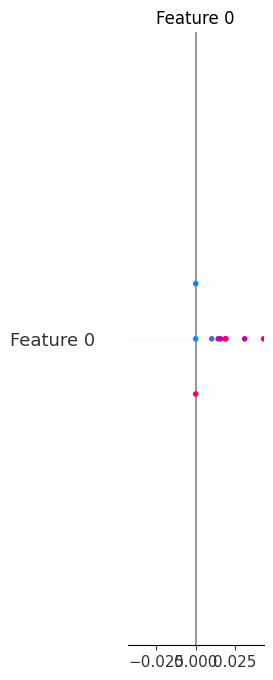

In [97]:
import shap

def get_reshaped_lstm_data(X_lstm):
    return X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1] * X_lstm.shape[2])

reshaped_X_lstm = get_reshaped_lstm_data(X_lstm)

# Train a simple Dense model on reshaped data for SHAP explanation
def train_dense_model(X, y):
    model = Sequential()
    model.add(Dense(units=50, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)
    return model

dense_model = train_dense_model(reshaped_X_lstm, y_lstm)

#SHAP Explanation for LSTM (Flattened Input)

explainer_lstm = shap.KernelExplainer(dense_model.predict, reshaped_X_lstm[:100])
shap_values_lstm = explainer_lstm.shap_values(reshaped_X_lstm[:10], nsamples=100)

# SHAP summary plot for the Dense model
shap.summary_plot(shap_values_lstm, reshaped_X_lstm[:10])


**Visualization**
*Line Chart*

In [98]:
line_fig = go.Figure()
line_fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='FTSE100 Line'))
line_fig.add_trace(go.Scatter(x=[data.index[-1] + pd.Timedelta(minutes=1)], y=[today_price_lr], mode='markers', name='Predicted LR Price'))
line_fig.add_trace(go.Scatter(x=[data.index[-1] + pd.Timedelta(minutes=1)], y=[today_price_lstm], mode='markers', name='Predicted LSTM Price'))
line_fig.update_layout(title='FTSE100 Index - Line Chart with Predicted Price', xaxis_title='Time', yaxis_title='Price')
line_fig.show()

*Candlestick Chart*

In [20]:
candle_fig = go.Figure()
candle_fig.add_trace(go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='FTSE100 Candlestick'))
candle_fig.update_layout(title='FTSE100 Index - Candlestick Chart', xaxis_title='Time', yaxis_title='Price')
candle_fig.show()

*Moving Average*

In [21]:
ma_fig = go.Figure()
ma_fig.add_trace(go.Scatter(x=data.index, y=data['Moving Average'], mode='lines', name='Moving Average'))
ma_fig.update_layout(title='FTSE100 Index - 20-Period Moving Average', xaxis_title='Time', yaxis_title='Price')
ma_fig.show()

*Linear Regression Prediction Plot*

In [22]:
data['Predicted Close'] = linear_model.predict(data[['Close']])
lr_fig = go.Figure()
lr_fig.add_trace(go.Scatter(x=data.index, y=data['Predicted Close'], mode='lines', name='Linear Regression Prediction'))
lr_fig.update_layout(title='FTSE100 Index - Linear Regression Prediction', xaxis_title='Time', yaxis_title='Price')
lr_fig.show()

*ARIMA Forecast Plot*

In [23]:
arima_fig = go.Figure()
arima_fig.add_trace(go.Scatter(x=forecast_index, y=arima_forecast, mode='lines', name='ARIMA Forecast'))
arima_fig.update_layout(title=f'FTSE100 Index - ARIMA Forecast (MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f})', xaxis_title='Time', yaxis_title='Price')
arima_fig.show()

*LSTM Forecast Plot*

In [24]:
lstm_fig = go.Figure()
lstm_fig.add_trace(go.Scatter(x=forecast_index, y=lstm_forecast, mode='lines', name='LSTM Forecast'))
lstm_fig.update_layout(title=f'FTSE100 Index - LSTM Forecast (MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f})', xaxis_title='Time', yaxis_title='Price')
lstm_fig.show()

In [48]:
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
prophet_fig = go.Figure()
prophet_fig.add_trace(go.Scatter(x=prophet_forecast['ds'], y=prophet_forecast['yhat'], mode='lines', name='Prophet Forecast'))
prophet_fig.update_layout(title='FTSE100 Index - Prophet Forecast (Long-Term)', xaxis_title='Date', yaxis_title='Predicted Price')
prophet_fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

